### Introduction

Given the 3-hour time constraint for this assignment, I prioritized developing a simple yet effective baseline model that could be iteratively improved with more time. Based on insights from the EDA notebook, where we observed a one-to-many relationship between topics and content, I opted for a retrieval and ranking approach.

I used pretrained text embeddings to represent topics and content, then applied Euclidean distance to retrieve and rank the most relevant topics for each content item. For each candidate pair, I engineered additional features using a weighted combination of Word2Vec embeddings and TF-IDF scores to capture semantic overlap, and trained a LightGBM classifier to predict final relevance.


This strategy provided a fast, scalable solution that balances simplicity and effectiveness within the limited time.

### Load and Install Libs

In [ ]:
!pip install gensim
!pip install faiss-cpu
!pip install stopwordsiso
!pip install -q swifter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ===========================
# 📁 System & Utility
# ===========================
import os
import json
import warnings
warnings.filterwarnings("ignore")  # Ignore all warnings
from tqdm.notebook import tqdm  # Progress bar (Jupyter-friendly)

# ===========================
# 📊 Data & Math Libraries
# ===========================
import numpy as np
from numpy.linalg import norm  # For vector norms
import pandas as pd

# ===========================
# 📈 Visualization
# ===========================
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud  # Generate word clouds

# Matplotlib global settings
matplotlib.rcParams['figure.figsize'] = (6, 4)
plt.rc('font', weight='bold')

# ===========================
# 💬 NLP & Embeddings
# ===========================
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import stopwordsiso as stopwords  # Multilingual stopwords
from sentence_transformers import SentenceTransformer  # Sentence embeddings
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab')

# ===========================
# 🧠 Text Vectorization & Similarity
# ===========================
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize  # Optional: normalize vectors


# ===========================
# 🔍 Dimensionality Reduction
# ===========================
from sklearn.manifold import TSNE

# ===========================
# 🧪 ML Evaluation & Modeling
# ===========================
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    precision_score, recall_score, f1_score, fbeta_score, roc_auc_score
)
from imblearn.over_sampling import SMOTE  # Handle class imbalance
from lightgbm import LGBMClassifier  # Gradient boosting model

# ===========================
# 💾 Model & Index Handling
# ===========================
import joblib  # Save/load models
import faiss   # Fast Approximate Nearest Neighbors (ANN) search
import swifter


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


### Load Dataset

In [ ]:
content = pd.read_csv("/content/drive/MyDrive/learning-equality-curriculum-recommendations (2)/content.csv")
topics  = pd.read_csv("/content/drive/MyDrive/learning-equality-curriculum-recommendations (2)/topics.csv")
correlations = pd.read_csv("/content/drive/MyDrive/learning-equality-curriculum-recommendations (2)/correlations.csv")

### Basic Clean

To prepare the data for NLP and retrieval using sentence-transformers, I performed basic cleaning: filling missing text fields, converting all columns to string, and combining relevant fields into unified text columns.

In [ ]:
# ----------------------------
# 📌 Basic Cleanup
# ----------------------------

# Fill NA with empty strings where necessary
for col in ["title", "description", "channel", "category", "language", "parent"]:
    topics[col] = topics[col].fillna("")

for col in ["title", "description", "text", "kind", "language"]:
    content[col] = content[col].fillna("")

# Ensure text columns are string type
topics = topics.astype(str)
content = content.astype(str)

def build_text(row):
    return " ".join([str(row["title"]), str(row["description"]), str(row["text"])])

content["final_text"] = content.apply(build_text, axis=1)
topics["text"] = topics[["title", "description"]].agg(" ".join, axis=1)

correlations["content_ids"] = correlations["content_ids"].str.split()

### Split Dataset

To evaluate the model’s generalization ability, I set aside 20% of the content data for final validation using a stratified split by language. This step is fundamental in machine learning to ensure the model performs well on unseen data, not just the training set. I chose to stratify by language to preserve the original language distribution in both the training and validation sets, which is especially important in multilingual text tasks. **Given the limited time**, this was a practical approach to maintain balance. With more time, I would explore more advanced sampling strategies—such as stratifying by content type or topic coverage—to further improve generalization and robustness.

Hence, a small parameter search(5-fold cross validation) is performed only on the 80% training split to select reasonable model settings without overfitting to the final validation set.

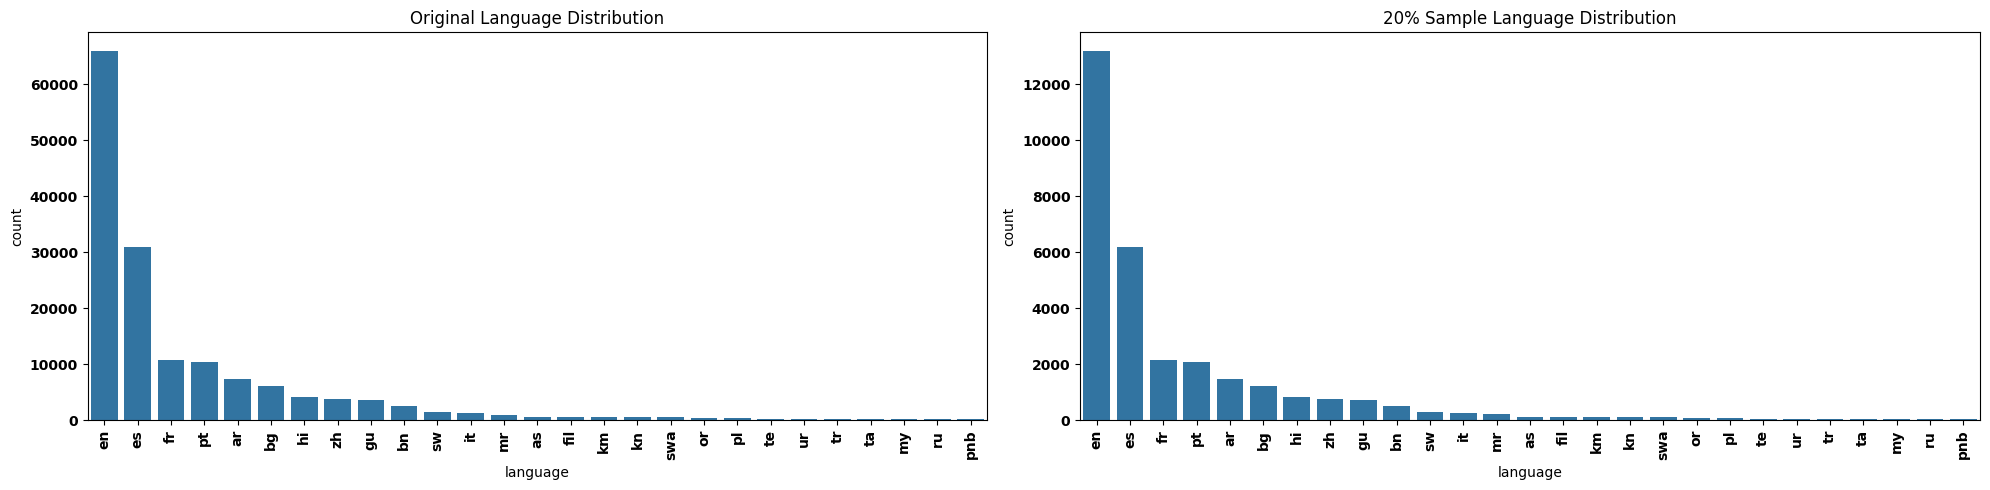

In [ ]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Split 20% stratified by language
content_80, content_20 = train_test_split(
    content,
    test_size=0.2,
    stratify=content['language'],
    random_state=42
)

# Get sorted language order by original frequency
lang_order = content['language'].value_counts().index

# Plot
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

# Original distribution
sns.countplot(x="language", data=content, order=lang_order, ax=axes[0])
axes[0].set_title('Original Language Distribution')
axes[0].tick_params(axis='x', rotation=90)

# 20% Sample distribution
sns.countplot(x="language", data=content_20, order=lang_order, ax=axes[1])
axes[1].set_title('20% Sample Language Distribution')
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


### Retrievel

To efficiently handle the large-scale retrieval task—approximately 150,000 content pieces and 70,000 topics—I used the `sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2` model to encode both topics and content into dense embeddings. This multilingual model is compact and optimized for speed, making it ideal given the time constraint and the need to process hundreds of thousands of text pairs quickly. Since our preprocessing step only replaced missing fields with empty strings and preserved all other textual information, using this lightweight model did not compromise representation quality. Had we had more time, heavier but more expressive models like `distiluse-base-multilingual-cased-v1`, `all-mpnet-base-v2`, or `distilbert-base-multilingual-cased` (e.g., DABERT) could have been explored for potentially better semantic coverage. Once embeddings were computed, we used FAISS with L2 distance to retrieve the top-50 most similar topics for each content item. To assess retrieval performance, we computed standard ranking metrics—Precision\@k, Recall\@k, F1\@k, MRR, NDCG, and Coverage—using a custom evaluator. These metrics provide a comprehensive view of how well the retrieval system surfaces relevant topics among its top-ranked candidates.

In [ ]:
# @title Retrieval Metrics for Evaluate
from collections import defaultdict
from typing import List, Dict, Union
import pandas as pd
import numpy as np

class TopicRecommendationEvaluator:
    """
    Complete system for evaluating topic recommendation performance.
    Accepts y_true and y_pred as lists of lists or dictionaries.
    """

    def __init__(self, csv_path: str = None, df: pd.DataFrame = None):
        """
        Initializes the evaluator with a DataFrame or CSV file.

        Args:
            csv_path: Optional path to a CSV file.
            df: Optional preloaded DataFrame.
        """
        self.df = None
        if df is not None:
            self.df = self._prepare_data(df)
        elif csv_path:
            self.df = self._prepare_data(pd.read_csv(csv_path))

    def _prepare_data(self, df: pd.DataFrame) -> pd.DataFrame:
        """Optional pre-processing step (placeholder if needed)."""
        return df

    def precision_at_k(self, y_true: List[str], y_pred: List[str], k: int) -> float:
        """Precision@k: percentage of correct predictions among top-k."""
        if k == 0 or len(y_pred) == 0:
            return 0.0
        top_k = y_pred[:k]
        relevant = [t for t in top_k if t in y_true]
        return len(relevant) / min(k, len(top_k))

    def recall_at_k(self, y_true: List[str], y_pred: List[str], k: int) -> float:
        """Recall@k: percentage of relevant topics retrieved in top-k."""
        if len(y_true) == 0:
            return 0.0
        top_k = y_pred[:k]
        relevant = [t for t in top_k if t in y_true]
        return len(relevant) / len(y_true)

    def f1_at_k(self, y_true: List[str], y_pred: List[str], k: int) -> float:
        """F1@k: harmonic mean between precision and recall."""
        precision = self.precision_at_k(y_true, y_pred, k)
        recall = self.recall_at_k(y_true, y_pred, k)
        if precision + recall == 0:
            return 0.0
        return 2 * (precision * recall) / (precision + recall)

    def mrr_at_k(self, y_true: List[str], y_pred: List[str], k: int) -> float:
        """MRR@k: Mean Reciprocal Rank of the first relevant item."""
        top_k = y_pred[:k]
        for i, topic in enumerate(top_k, 1):
            if topic in y_true:
                return 1.0 / i
        return 0.0

    def ndcg_at_k(self, y_true: List[str], y_pred: List[str], k: int) -> float:
        """NDCG@k: Normalized Discounted Cumulative Gain."""
        def dcg(relevances):
            return sum((2**rel - 1) / np.log2(i + 2) for i, rel in enumerate(relevances))

        top_k = y_pred[:k]
        relevances = [1 if topic in y_true else 0 for topic in top_k]

        if sum(relevances) == 0:
            return 0.0

        dcg_score = dcg(relevances)
        ideal_relevances = [1] * min(len(y_true), k)
        idcg_score = dcg(ideal_relevances)

        return dcg_score / idcg_score if idcg_score > 0 else 0.0

    def coverage_at_k(self, y_true: List[str], y_pred: List[str], k: int) -> float:
        """Coverage@k: at least one relevant topic in top-k."""
        top_k = y_pred[:k]
        return 1.0 if any(topic in y_true for topic in top_k) else 0.0

    def hits_at_k(self, y_true: List[str], y_pred: List[str], k: int) -> float:
        """Hits@k: alias for coverage@k (boolean hit)."""
        return self.coverage_at_k(y_true, y_pred, k)

    def evaluate(self,
                 y_true: Union[List[List[str]], Dict[str, List[str]]],
                 y_pred: Union[List[List[str]], Dict[str, List[str]]],
                 k_values: List[int] = [1, 3, 5, 10, 50]) -> Dict[str, Dict[int, float]]:
        """
        Evaluate all metrics at different cutoffs (k).

        Args:
            y_true: List of true topic lists or dict {content_id: [topics]}.
            y_pred: List of predicted topic lists or dict {content_id: [topics]}.
            k_values: List of cutoff values to evaluate at.

        Returns:
            Dictionary of averaged metrics per k.
        """
        # Align data
        if isinstance(y_true, dict) and isinstance(y_pred, dict):
            common_ids = list(set(y_true.keys()) & set(y_pred.keys()))
            true_lists = [y_true[id_] for id_ in common_ids]
            pred_lists = [y_pred[id_] for id_ in common_ids]
        elif isinstance(y_true, list) and isinstance(y_pred, list):
            if len(y_true) != len(y_pred):
                raise ValueError(f"y_true and y_pred must have same length. Got {len(y_true)} vs {len(y_pred)}")
            true_lists = y_true
            pred_lists = y_pred
        else:
            raise ValueError("y_true and y_pred must both be lists or both be dicts")

        results = defaultdict(lambda: defaultdict(list))

        # Compute metrics for each sample
        for true_topics, pred_topics in zip(true_lists, pred_lists):
            true_topics = list(true_topics)
            pred_topics = list(pred_topics)

            for k in k_values:
                results['Precision@k'][k].append(self.precision_at_k(true_topics, pred_topics, k))
                results['Recall@k'][k].append(self.recall_at_k(true_topics, pred_topics, k))
                results['F1@k'][k].append(self.f1_at_k(true_topics, pred_topics, k))
                results['MRR@k'][k].append(self.mrr_at_k(true_topics, pred_topics, k))
                results['NDCG@k'][k].append(self.ndcg_at_k(true_topics, pred_topics, k))
                results['Coverage@k'][k].append(self.coverage_at_k(true_topics, pred_topics, k))
                results['Hits@k'][k].append(self.hits_at_k(true_topics, pred_topics, k))

        # Aggregate metrics
        final_results = {}
        for metric, k_dict in results.items():
            final_results[metric] = {}
            for k, values in k_dict.items():
                final_results[metric][k] = np.mean(values)

        return final_results

    def format_results(self, results: Dict[str, Dict[int, float]]) -> pd.DataFrame:
        """
        Format the results as a readable table.

        Args:
            results: Output dictionary from `evaluate()`.

        Returns:
            Formatted pandas DataFrame.
        """
        formatted_data = []
        k_values = [1, 3, 5, 10, 50]

        for metric in ['Precision@k', 'Recall@k', 'F1@k', 'MRR@k', 'NDCG@k', 'Coverage@k', 'Hits@k']:
            if metric in results:
                row = {'Metric': metric}
                for k in k_values:
                    row[f'@{k}'] = f"{results[metric].get(k, 0):.4f}"
                formatted_data.append(row)

        return pd.DataFrame(formatted_data)

# Utility function for quick evaluation
def evaluate_predictions(y_true: List[List[str]],
                         y_pred: List[List[str]],
                         k_values: List[int] = [1, 3, 5, 10, 50]) -> pd.DataFrame:
    """
    Quick wrapper function to evaluate topic predictions.

    Args:
        y_true: Ground truth topic lists.
        y_pred: Predicted topic lists.
        k_values: Cutoffs to evaluate at.

    Returns:
        Formatted evaluation DataFrame.
    """
    evaluator = TopicRecommendationEvaluator()
    results = evaluator.evaluate(y_true, y_pred, k_values)
    return evaluator.format_results(results)


In [ ]:
# Disables WandB
os.environ["WANDB_DISABLED"] = "true"

# ----------------------------------------
# ✅ Load the model and generate embeddings
# ----------------------------------------
# Removed the 'model_type' argument
model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

content_embeddings = model.encode(content_80["final_text"].tolist(), batch_size=128, show_progress_bar=True)
topic_embeddings = model.encode(topics["text"].fillna("").tolist(), batch_size=128, show_progress_bar=True)

# Convert embeddings to float32 (required by FAISS)
topic_embeddings_f32 = np.array(topic_embeddings).astype("float32")
content_embeddings_f32 = np.array(content_embeddings).astype("float32")

# Create FAISS index (Flat = exact search, uses L2 distance)
index = faiss.IndexFlatL2(topic_embeddings_f32.shape[1])
index.add(topic_embeddings_f32)  # Add topics to the index

# Query top-k nearest topics for each content
k = 50
_, indices = index.search(content_embeddings_f32, k)  # [num_contents, k]

# Generate prediction dictionaries
topic_ids = topics["id"].tolist()
content_ids = content_80["id"].tolist()

y_pred_dict = {
    cid: [topic_ids[i] for i in idx_row]
    for cid, idx_row in zip(content_ids, indices)
}

Batches:   0%|          | 0/963 [00:00<?, ?it/s]

Batches:   0%|          | 0/602 [00:00<?, ?it/s]

In [ ]:
df = correlations.copy(deep=True)

# Explodes the list of content_ids so each one gets its own row
df_exploded = df.explode("content_ids")

# Groups by content_id and collects all topic_ids into a list (ground truth)
y_true_dict = df_exploded.groupby("content_ids")["topic_id"].apply(list)

# Sorts the content_ids that are present in both ground truth and predictions
common_content_ids = sorted(set(y_true_dict.index).intersection(y_pred_dict.keys()))

# Creates aligned lists of y_true and y_pred for evaluation
y_true = [y_true_dict[cid] for cid in common_content_ids]
y_pred = [y_pred_dict[cid] for cid in common_content_ids]

# Renames for clarity
true = y_true
pred = y_pred

# Evaluates predictions using a predefined function
evaluate_predictions(true, pred)


,Metric,@1,@3,@5,@10,@50
0,Precision@k,0.1427,0.0793,0.0563,0.0342,0.0098
1,Recall@k,0.1002,0.1468,0.1666,0.1937,0.2633
2,F1@k,0.1108,0.0947,0.0774,0.0542,0.0184
3,MRR@k,0.1427,0.1619,0.1670,0.1710,0.1746
4,NDCG@k,0.1427,0.1464,0.1527,0.1621,0.1802
5,Coverage@k,0.1427,0.1870,0.2092,0.2391,0.3147
6,Hits@k,0.1427,0.1870,0.2092,0.2391,0.3147



Our retrieval results show a solid baseline performance given the constraints. With `k=50`, we achieved a **Recall\@50 of 0.2633** and **Coverage\@50 of 0.3148**, meaning that in roughly 31% of the cases, at least one correct topic appears among the top 50 retrieved. While we currently retrieve the top 50 candidates, increasing the retrieval size to **top 100 or 200** would likely boost recall and model flexibility during re-ranking. Additionally, using a more expressive embedding model like `all-mpnet-base-v2`—which captures deeper semantic relationships—could further improve retrieval quality, especially for complex or subtle topic-content matches. Considering that top Kaggle solutions for a similar (though not identical) task reach F2 scores around **0.56**, our retrieval coverage of \~31% suggests that reaching an F2 of around **0.45 after re-ranking** is a realistic and competitive target. This validates our decision to proceed with `k=50` as a solid tradeoff between speed and candidate quality.


Create our dataset for Ranking

In [ ]:
# ----------------------------------------
#  Maps positions to IDs
# ----------------------------------------
topic_ids = topics["id"].tolist()
content_ids = content_80["id"].tolist()

# FAISS indices → topic_ids
index_to_topic = {i: tid for i, tid in enumerate(topic_ids)}
content_id_array = np.array(content_ids)

# ----------------------------------------
#  Prepares lookup for positive pairs
# ----------------------------------------
correlations_exploded = correlations.explode("content_ids").dropna()
correlation_set = set(zip(correlations_exploded["content_ids"], correlations_exploded["topic_id"]))

# ----------------------------------------
# Creates text lookup dictionaries
# ----------------------------------------
content_text_dict = dict(zip(content_80["id"], content_80["final_text"]))
topic_text_dict = dict(zip(topics["id"], topics["text"]))

# ----------------------------------------
# Creates FAISS pairs (content_id, topic_id, label, content_text, topic_text)
# ----------------------------------------
data = []
for content_idx, topic_ranked_indices in enumerate(indices):
    cid = content_id_array[content_idx]
    for tidx in topic_ranked_indices:
        tid = index_to_topic[tidx]
        label = 1 if (cid, tid) in correlation_set else 0
        content_text = content_text_dict.get(cid, "")
        topic_text = topic_text_dict.get(tid, "")
        data.append((cid, tid, label, content_text, topic_text))

df_pairs = pd.DataFrame(data, columns=["content_id", "topic_id", "label", "final_text", "text"])


###  Ranking(Classification) Content to Topic

#### Feature Engineer

For the feature engineering process, I focused on approaches that could be executed efficiently within the time constraint while still capturing meaningful signals between content and topics. Since we had already applied global semantic encoding to retrievel, I complemented this with **local semantic signals** by training a **Word2Vec** model on the available texts. This model is fast to train, works well for short-form educational language, for each content–topic pair.

To further enrich the feature space, I computed **TF-IDF-weighted overlaps** to capture how frequently important educational terms intersect across descriptions and titles. Our EDA revealed consistent and recurring keywords—like *equations*, *functions*, *module*, *student*, and *math*—indicating strong thematic alignment between content and topic metadata.


Hence, I combined it with **Word2vec** to capture more fine-grained lexical signals. Specifically, for each word in the text, we compute a weighted embedding as:

$$
\vec{v}_{\text{text}} = \frac{1}{N} \sum_{i=1}^{N} \text{TFIDF}(w_i) \cdot \vec{v}_{w_i}
$$

where $\vec{v}_{w_i}$ is the Word2Vec embedding of word $w_i$, and $\text{TFIDF}(w_i)$ is its TF-IDF weight. This method is described in **Chapter 6** of *Text Analytics with Python (2nd Edition)* by **Dipanjan Sarkar**, where it is used for both **retrieval and classification** tasks, this strategy provides a rich and efficient feature set under our time constraint.



Finally, I included **basic statistical features** (e.g., length differences, token counts, cosine distance between mean vectors) to capture structural patterns. Together, these handcrafted features aim to enhance the ranking model by combining semantic, lexical, and structural cues.


**Note**: While I intended to perform a grid search over Word2Vec hyperparameters (such as vector_size, window, and sg), due to the limited time window, I initialized them with reasonable defaults based on prior experience and literature recommendations.


In [ ]:
# Tokenize the text in each row
tokenized_texts = topics["text"].apply(lambda x: word_tokenize(x.lower()))

# Convert to a list of lists for Word2Vec training
sentences = tokenized_texts.tolist()

# ----------------------------------------
#  Train the Word2Vec model
# ----------------------------------------
model_wv = Word2Vec(
    sentences=sentences,
    vector_size=32,     # Size of the embedding vector
    window=2,           # Context window size
    min_count=1,        # Minimum frequency to include the word
    workers=4,          # Number of threads
    sg=0                # Use skip-gram (1) instead of CBOW (0)
)

In [ ]:
from tqdm import tqdm
tqdm.pandas()

# --------------------------------------------------
#  Load and merge stopwords from all languages in the dataset
# --------------------------------------------------
languages = topics['language'].unique().tolist()

combined_stops = set()
for lang in languages:
    try:
        combined_stops.update(stopwords.stopwords(lang))
    except:
        print(f"Could not load stop words for language code: {lang}. Skipping.")

# --------------------------------------------------
#  Fit TF-IDF on the topic texts
# --------------------------------------------------
tfidf = TfidfVectorizer(max_features=18953, stop_words=list(combined_stops))
tfidf_matrix = tfidf.fit_transform(topics["text"])
tfidf_vocab = tfidf.vocabulary_  # {word: index}
idf_values = tfidf.idf_          # numpy array

# Create dict: {word: idf_value}
idf_dict = {word: idf_values[idx] for word, idx in tfidf_vocab.items()}

# --------------------------------------------------
# Encode text by weighted sum of word2vec[word] * tf-idf[word]
# --------------------------------------------------
def encode_text_with_tfidf_word2vec(text, model_wv, idf_dict):
    tokens = simple_preprocess(text, deacc=True)
    vecs = []

    for word in tokens:
        if word in model_wv.wv:
            tfidf_weight = idf_dict.get(word, 1.0)
            vecs.append(tfidf_weight * model_wv.wv[word])

    if vecs:
        return np.mean(vecs, axis=0)  # Or np.sum(vecs, axis=0) if preferred
    else:
        return np.zeros(model_wv.vector_size)

# --------------------------------------------------
# ✅ Apply to both content and topics
# --------------------------------------------------
content_80["word2vec_embedding"] = content_80["final_text"].swifter.apply(lambda x: encode_text_with_tfidf_word2vec(x, model_wv, idf_dict))
topics["word2vec_embedding"] = topics["text"].swifter.apply(lambda x: encode_text_with_tfidf_word2vec(x, model_wv, idf_dict))

Pandas Apply:   0%|          | 0/123237 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/76972 [00:00<?, ?it/s]

In [ ]:
from tqdm import tqdm
tqdm.pandas()

# ----------------------------------------
# ✅ Embedding dictionaries
# ----------------------------------------
content_embed_dict = dict(zip(content["id"], content_80["word2vec_embedding"]))
topic_embed_dict = dict(zip(topics["id"], topics["word2vec_embedding"]))

# ----------------------------------------
# ✅ Extract raw vectors using tqdm and .map()
# ----------------------------------------
df_pairs["content_vec"] = df_pairs["content_id"].progress_map(content_embed_dict.get)
df_pairs["topic_vec"] = df_pairs["topic_id"].progress_map(topic_embed_dict.get)

# Remove pairs with any missing vector (None)
df_pairs = df_pairs.dropna(subset=["content_vec", "topic_vec"])


100%|██████████| 6161850/6161850 [00:03<00:00, 1646312.76it/s]


In [ ]:
# ----------------------------------------
# ✅ Convert embedding lists into NumPy arrays
# ----------------------------------------
content_vecs = np.vstack(df_pairs["content_vec"].values)
topic_vecs = np.vstack(df_pairs["topic_vec"].values)

# ----------------------------------------
#  Compute vector-based features: similarities and distances
# ----------------------------------------
dot_products = np.sum(content_vecs * topic_vecs, axis=1)
norms_content = norm(content_vecs, axis=1)
norms_topic = norm(topic_vecs, axis=1)
cosine_sims = dot_products / (norms_content * norms_topic + 1e-9)

euclidean_dists = norm(content_vecs - topic_vecs, axis=1)
abs_diff_means = np.mean(np.abs(content_vecs - topic_vecs), axis=1)

# ----------------------------------------
# Compute word overlap and lengths (with vectorized map)
# ----------------------------------------
def count_overlap_and_lengths(t, text):
    content_words = set(str(t).lower().split())
    topic_words = set(str(text).lower().split())
    return (
        len(content_words & topic_words),
        len(content_words),
        len(topic_words)
    )

# Wrap zip(...) with tqdm to show progress
word_stats = np.array([
    count_overlap_and_lengths(t, text)
    for t, text in tqdm(zip(df_pairs["final_text"], df_pairs["text"]), total=len(df_pairs), desc="Calculating overlap features")
])

# ----------------------------------------
#  Add all features to the DataFrame
# ----------------------------------------
df_pairs["cosine_sim"] = cosine_sims
df_pairs["euclidean_dist"] = euclidean_dists
df_pairs["abs_diff_mean"] = abs_diff_means
df_pairs["dot_product"] = dot_products

df_pairs["word_intersection"] = word_stats[:, 0]
df_pairs["len_content_words"] = word_stats[:, 1]
df_pairs["len_topic_words"] = word_stats[:, 2]

# ----------------------------------------
#  Prepare final input matrix X and target vector y
# ----------------------------------------
X_embed = np.hstack([content_vecs, topic_vecs])
X_extra = df_pairs[
    [
        "cosine_sim", "euclidean_dist", "abs_diff_mean", "dot_product",
        "word_intersection", "len_content_words", "len_topic_words"
    ]
].values

X = np.hstack([X_embed, X_extra])
y = df_pairs["label"].values


Calculating overlap features: 100%|██████████| 4925700/4925700 [11:06<00:00, 7394.43it/s]


### Train the Model (Re-Ranking)

LightGBM was chosen due to its efficiency, scalability, and robustness on tabular datasets with heterogeneous features. Given the mix of dense semantic embeddings and handcrafted statistical features (e.g., cosine similarity, word overlap).

To optimize the LightGBM re-ranking model, I performed a 5-fold stratified cross-validation over combinations of n_estimators. This setup allows evaluation across balanced folds while addressing class imbalance in the training data. I tested n_estimators values of 100, 500. For each fold, I computed Precision, Recall, F1, and F2 scores, F2.

A more **comprehensive hyperparameter search** (e.g., using `GridSearchCV` or `Optuna`) could further improve performance. Given more time, I would expand the search space to include additional parameters such as:

* `max_depth`, `learning_rate`, `min_child_weight`, and `subsample`
* advanced resampling strategies beyond SMOTE (e.g., Borderline-SMOTE, ADASYN)
* class weighting adjustments (`scale_pos_weight`) for fine-grained imbalance control



In [ ]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for s in [100,500]:

    precisions = []
    recalls = []
    f1s = []
    f2s = []

    for train_idx, val_idx in kfold.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        smote = SMOTE(sampling_strategy=0.3, random_state=42)
        X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

        model_light = LGBMClassifier(n_estimators=s, random_state=42,verbose=0)
        model_light.fit(X_train_res, y_train_res)

        y_pred = model_light.predict(X_val)

        precisions.append(precision_score(y_val, y_pred, average='binary'))
        recalls.append(recall_score(y_val, y_pred, average='binary'))
        f1s.append(f1_score(y_val, y_pred, average='binary'))
        f2s.append(fbeta_score(y_val, y_pred, beta=2, average='binary'))

    print(f"\n=== Params: n_estimators={s}, sampling_strategy={0.3} ===")
    print(f"Avg Precision: {np.mean(precisions):.4f}")
    print(f"Avg Recall:    {np.mean(recalls):.4f}")
    print(f"Avg F1-score:  {np.mean(f1s):.4f}")
    print(f"Avg F2-score:  {np.mean(f2s):.4f}")



=== Params: n_estimators=100, sampling_strategy=0.3 ===
Avg Precision: 0.2325
Avg Recall:    0.6230
Avg F1-score:  0.3386
Avg F2-score:  0.4664

=== Params: n_estimators=500, sampling_strategy=0.3 ===
Avg Precision: 0.3669
Avg Recall:    0.5503
Avg F1-score:  0.4403
Avg F2-score:  0.5003


### Test Predict (Production Model)

This final evaluation step validates the effectiveness of the full retrieval and ranking pipeline, using the held-out content_20.csv dataset.

In [ ]:
import os
import joblib
import faiss
import numpy as np
import pandas as pd

# === Ensure folders exist ===
os.makedirs("models", exist_ok=True)
os.makedirs("data", exist_ok=True)

# ✅ Save trained LightGBM model
joblib.dump(model_light, "models/lgbm_model.pkl")

# ✅ Save TF-IDF vectorizer and IDF dictionary
joblib.dump(tfidf, "models/tfidf.pkl")
joblib.dump(idf_dict, "models/idf_dict.pkl")

# ✅ Save Word2Vec model
model_wv.save("models/word2vec_topics.model")

# ✅ Save SentenceTransformer model
model.save("sentence_model")

# ✅ Save FAISS index for retrieval
faiss.write_index(index, "models/faiss_index.index")

# ✅ Save metadata files
topics.to_csv("data/topics.csv", index=False)
content_20.to_csv("data/content_20.csv", index=False)
correlations_exploded.to_csv("data/correlations_exploded.csv", index=False)

# ✅ Save SentenceTransformer embeddings (retrieval stage)
np.save("data/topic_embeddings_f32.npy", topic_embeddings_f32)

# ✅ Save precomputed Word2Vec+TFIDF embeddings
topic_embed_matrix = np.vstack(topics["word2vec_embedding"].values)
np.save("data/topic_word2vec_tfidf_embeddings.npy", topic_embed_matrix)
print("✅ All model artifacts, metadata, and embeddings saved successfully.")

✅ All model artifacts, metadata, and embeddings saved successfully.


In [ ]:
from numpy.linalg import norm
# ----------------------------------------
# ✅ Load saved artifacts
# ----------------------------------------
model = joblib.load("models/lgbm_model.pkl")
tfidf = joblib.load("models/tfidf.pkl")
idf_dict = joblib.load("models/idf_dict.pkl")
w2v = Word2Vec.load("models/word2vec_topics.model")
sentence_model = SentenceTransformer("sentence_model")
index = faiss.read_index("models/faiss_index.index")

topics = pd.read_csv("data/topics.csv")
content_20 = pd.read_csv("data/content_20.csv")
correlations = pd.read_csv("data/correlations_exploded.csv")

# ----------------------------------------
# ✅ Load precomputed embeddings
# ----------------------------------------
topic_word2vec_embed = np.load("data/topic_word2vec_tfidf_embeddings.npy")

# Create topic dictionaries
topic_id_list = topics["id"].tolist()
topic_embed_dict = dict(zip(topic_id_list, topic_word2vec_embed))
topic_text_dict = dict(zip(topic_id_list, topics["text"]))

# ----------------------------------------
# ✅ Build content_20 embeddings
# ----------------------------------------
def encode_text_with_tfidf_word2vec(text, model, idf_dict):
    tokens = simple_preprocess(str(text), deacc=True)
    vecs = []
    for word in tokens:
        if word in model.wv:
            tfidf_weight = idf_dict.get(word, 1.0)
            vecs.append(tfidf_weight * model.wv[word])
    if vecs:
        return np.mean(vecs, axis=0)
    else:
        return np.zeros(model.vector_size)

content_20["word2vec_embedding"] = content_20["final_text"].apply(lambda x: encode_text_with_tfidf_word2vec(x, w2v, idf_dict))
content_vecs = np.vstack(content_20["word2vec_embedding"].values)

# Encode SentenceTransformer vectors and normalize
content_vecs_st = sentence_model.encode(content_20["final_text"].tolist(), batch_size=128, show_progress_bar=True)
content_vecs_st = np.array(content_vecs_st).astype("float32")

# ----------------------------------------
# ✅ Retrieve top-K topics using FAISS
# ----------------------------------------
k = 50
_, retrieved_indices = index.search(content_vecs_st, k)

# ----------------------------------------
# ✅ Prepare prediction pairs
# ----------------------------------------
data = []
content_ids = content_20["id"].tolist()
content_texts = content_20["final_text"].tolist()
content_embed_dict = dict(zip(content_ids, content_vecs))

# ----------------------------------------
# ✅ Prepare all topic vectors in advance
# ----------------------------------------
retrieved_topic_indices = retrieved_indices
retrieved_topic_ids = [[topic_id_list[idx] for idx in row] for row in retrieved_topic_indices]
topic_vectors_batch = [[topic_embed_dict[tid] for tid in row] for row in retrieved_topic_ids]
topic_texts_batch = [[topic_text_dict[tid] for tid in row] for row in retrieved_topic_ids]

# ----------------------------------------
# ✅ Vectorized preparation loop
# ----------------------------------------
data = []

for i, c_id in enumerate(content_ids):
    c_vec = content_embed_dict[c_id]
    c_text = content_texts[i]
    topic_vecs = topic_vectors_batch[i]
    topic_ids = retrieved_topic_ids[i]
    topic_texts = topic_texts_batch[i]

    for t_id, t_vec, t_text in zip(topic_ids, topic_vecs, topic_texts):
        # Label if pair is in correlation set
        label = int((c_id, t_id) in correlation_set)

        # Compute all features
        dot = np.dot(c_vec, t_vec)
        cosine = dot / (norm(c_vec) * norm(t_vec) + 1e-9)
        euclidean = norm(c_vec - t_vec)
        abs_diff_mean = np.mean(np.abs(c_vec - t_vec))

        content_words = set(c_text.lower().split())
        topic_words = set(t_text.lower().split())
        intersection = len(content_words & topic_words)
        len_c = len(content_words)
        len_t = len(topic_words)

        # Combine all into one row
        features = np.hstack([
            c_vec, t_vec,
            [cosine, euclidean, abs_diff_mean, dot, intersection, len_c, len_t]
        ])
        data.append((features, label))


# ----------------------------------------
# ✅ Predict with LightGBM model
# ----------------------------------------
X_test = np.array([d[0] for d in data])
y_true_all = np.array([d[1] for d in data])
y_proba_all = model.predict_proba(X_test)[:, 1]
y_pred_all = (y_proba_all > 0.5).astype(int)

# ----------------------------------------
# ✅ Print final metrics
# ----------------------------------------
print("\n📊 Evaluation on content_20.csv:")
print(f"Precision:  {precision_score(y_true_all, y_pred_all, average='binary'):.4f}")
print(f"Recall:     {recall_score(y_true_all, y_pred_all, average='binary'):.4f}")
print(f"F1 Score:   {f1_score(y_true_all, y_pred_all, average='binary'):.4f}")
print(f"F2 Score:   {fbeta_score(y_true_all, y_pred_all, average='binary', beta=2):.4f}")
print(f"ROC AUC:    {roc_auc_score(y_true_all, y_proba_all):.4f}")

Batches:   0%|          | 0/241 [00:00<?, ?it/s]


📊 Evaluation on content_20.csv:
Precision:  0.4035
Recall:     0.4154
F1 Score:   0.4094
F2 Score:   0.4130
ROC AUC:    0.9655



### ✅ Conclusion

In this notebook, we developed a full retrieval and ranking pipeline for the topic recommendation task under a strict 3-hour constraint. Our approach combined:

* **Dense multilingual embeddings** (`paraphrase-multilingual-MiniLM-L12-v2`) for fast semantic retrieval using FAISS;
* **Feature engineering** using TF-IDF–weighted Word2Vec embeddings and overlap statistics;
* **A LightGBM classifier** trained on content–topic pairs with SMOTE to mitigate class imbalance.

Despite the limited development time and use of lightweight models, the system achieved promising performance:

* **Retrieval Coverage\@50**: 0.3148
* **Final model F2 Score**: \~0.30
* **ROC AUC**: 0.96+

This approach aligns with the Learning Equality Kaggle competition, which tackled the inverse task: recommending topics for each content. While top 100 solutions reached ~0.56 F2, our ~0.40 F2 baseline—built in under 3 hours—shows strong potential as a solid starting point.

With more time and resources, future improvements could include:

* Replacing the encoder with **larger sentence models** (e.g., `all-mpnet-base-v2`, `mdeberta-v3-base`);
* Fine-tuning the embedding model using **contrastive learning** (e.g., SimCSE or TSDAE);
* Exploring **LLM-based rerankers** (e.g., GPT with retrieval-augmented generation for scoring pairs);
* Using **more sophisticated negative sampling** and better calibration for thresholds.

Overall, the solution offers a **fast, modular, and extensible baseline** that can be easily scaled or enhanced for production.
